<a href="https://colab.research.google.com/github/ANNASBlackHat/Image-Search-OpenCV/blob/master/image_search_openCv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pip
!pip install Pillow
!pip install scipy==1.1.0
!pip install google_images_download

     |████████████████████████████████| 31.2MB 116kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.3
    Uninstalling scipy-1.3.3:
      Successfully uninstalled scipy-1.3.3


In [0]:
import cv2
import numpy as np
import scipy
from scipy.misc import imread
import _pickle as pickle
import random
import os
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive/')
drive_path = '/content/drive/My Drive/EXPERIMENT/Image Classification/Image Matcher/'

Mounted at /content/drive/


### Preparing Data
Download images from Google Image search

In [22]:
from google_images_download import google_images_download   

response = google_images_download.googleimagesdownload()  

arguments = {"keywords":"peralatan dapur","limit":100,"print_urls":False, "output_directory": drive_path+'datasets/train', "no_directory":True} 
paths = response.download(arguments)   
#print(paths)


Item no.: 1 --> Item name = peralatan dapur
Evaluating...
Starting Download...
Invalid or missing image format. Skipping...
Invalid or missing image format. Skipping...
Completed Image ====> 1.Peralatan-Dapur-Alat-Masak-Panci-Set.jpg
Completed Image ====> 2.tips-merawat-peralatan-dapur.jpg
URLError on an image...trying next one... Error: <urlopen error _ssl.c:835: The handshake operation timed out>
Invalid or missing image format. Skipping...
Completed Image ====> 3.5138555_6884a51c-4791-4207-bb92-b982d40ce9cf_1080_1080.jpg
Completed Image ====> 4.peralatan-dapur-png-4.png
Invalid or missing image format. Skipping...
Completed Image ====> 5.maxresdefault.jpg
Completed Image ====> 6.peralatan-dapur-png-3.png
Completed Image ====> 7.dapur-ikea.jpg
Completed Image ====> 8.peralatan-dapur-png-1.png
Completed Image ====> 9.peralatan-dapur-murah-meriah.jpg
Completed Image ====> 10.4942779_72933c63-d894-4fd9-99e2-da3d00e3dcd0_786_786.jpg
Completed Image ====> 11.CARA-MEMILIH-PERALATAN-DAPUR-

In [0]:
#function to extract feature from image
def extract_features(image_path, vector_size=32):
  image = imread(image_path, mode='RGB')
  try:
    alg = cv2.KAZE_create()
    
    kps = alg.detect(image)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    kps, dsc = alg.compute(image, kps)

    dsc = dsc.flatten()

    needed_size = (vector_size * 64)
    if dsc.size < needed_size:
      #adding zero
      desc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])

  except cv2.error as e:
    print('error : ',e)
    return None

  return dsc      

### Extracting Image Features
Extract all image features from train directory

In [96]:
images_dir = drive_path+'datasets/train'
db_path = drive_path+'features.pck'

files = [os.path.join(images_dir, p) for p in sorted(os.listdir(images_dir))]

result = {}
for f in files:  
  name = f.split('/')[-1]
  print(f"extracting feature from image {name.lower()}")
  result[name] = extract_features(f)

with open(db_path, 'wb') as fp:
  pickle.dump(result, fp)  

extracting feature from image 1.peralatan-dapur-alat-masak-panci-set.jpg


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


extracting feature from image 10.4942779_72933c63-d894-4fd9-99e2-da3d00e3dcd0_786_786.jpg
extracting feature from image 11.cara-memilih-peralatan-dapur-dengan-benar.jpg
extracting feature from image 12.untitled-design-15-3.jpg
extracting feature from image 13.peralatan-dapur-png-6.png
extracting feature from image 14.a1-peralatan-dapur-rak-kotak-tidak-ada-lubang-dinding-berputar-garam-rilis-msg-kreatif-toples-bumbu.jpg
extracting feature from image 15.grunka-4-piece-kitchen-utensil-set-stainless-steel__0711741_pe728430_s5.jpg
extracting feature from image 16.432624072.g_400-w-st_g.jpg
extracting feature from image 17.cropped-181115kitvauc-6753-1200x800.jpg
extracting feature from image 18.peralatan-dapur-dapur-rak-microwave-landing-lapisan-menerima-rak.jpg
extracting feature from image 19.gnarp-3-piece-kitchen-utensil-set__0711742_pe728431_s5.jpg
extracting feature from image 2.tips-merawat-peralatan-dapur.jpg
extracting feature from image 20.peralatan-dapur-png-2.png
extracting featur

### Build Matcher Function

**Load features from database**

In [97]:
names = []
matrix = []
data = {}

print(db_path)
print(os.path.getsize(db_path))

#extract features from database
with open(db_path, 'rb') as fp:
  data = pickle.load(fp)

for k, v in data.items():
  names.append(k) 
  matrix.append(v)

names = np.array(names)  
matrix = np.array(matrix)

/content/drive/My Drive/EXPERIMENT/Image Classification/Image Matcher/features.pck
713689


In [0]:
def cos_cdist(vector):
  #getting cosine distance betweeb search image and images in database
  v = vector.reshape(1, -1)
  return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)


def match(image_path, topn=5):
  features = extract_features(image_path)
  img_distances = cos_cdist(features)

  nearest_ids = np.argsort(img_distances)[:topn].tolist()
  nearest_img_path = names[nearest_ids].tolist()

  return nearest_img_path, img_distances[nearest_ids].tolist()


def show_img(path):
  img = imread(path, mode='RGB')
  plt.imshow(img)
  plt.show()

### Let's Play

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


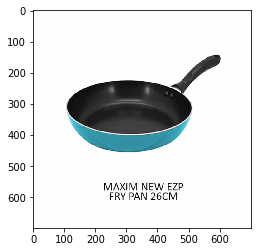

================= Searching...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


================= Result :
distance : 0.7420496401975493


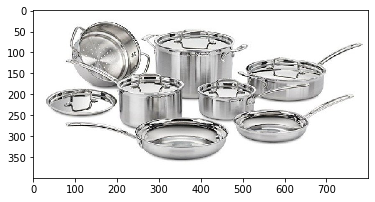

distance : 0.738717655869695


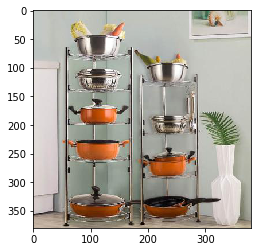

distance : 0.73194384836156


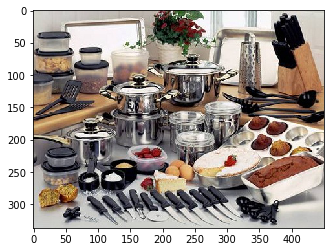

In [98]:
#put image in test folder to find the match from database
img_search = drive_path+'datasets/test/teflon.jpg'
show_img(img_search)

print('================= Searching...')
match_names, match_dist = match(img_search, topn=3)
print('================= Result :')

for i, (name, dist) in enumerate(zip(match_names, match_dist)):
  print(f"distance : {1-dist}")
  match_img_path = os.path.join(images_dir, name)      
  show_img(match_img_path)